In [174]:
#Download the dataset from opensig
"""import urllib.request
urllib.request.urlretrieve('http://opendata.deepsig.io/datasets/2016.10/RML2016.10a.tar.bz2', 'RML2016.10a.tar.bz2')"""

# The above line of code no longer works. the site format may have changed 

"import urllib.request\nurllib.request.urlretrieve('http://opendata.deepsig.io/datasets/2016.10/RML2016.10a.tar.bz2', 'RML2016.10a.tar.bz2')"

In [175]:
#decompress the .bz2 file into .tar file
import sys
import os
import bz2

zipfile = bz2.BZ2File("./RML2016.10a.tar.bz2") # open the file
data = zipfile.read() # get the decompressed data

In [176]:
#write the .tar file
open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

640952320

In [177]:
#extract the .tar file
import tarfile
my_tar = tarfile.open('./RML2016.10a.tar')
my_tar.extractall('./RadioML_data') # specify which folder to extract to
my_tar.close()

In [178]:
#extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("./RadioML_data/RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [179]:
# Import all the things we need ---
%matplotlib inline
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten,LayerNormalization
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

In [180]:
# Partition the data into training and test sets of the form we can train/test on 
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
#len(train_idx)

In [181]:
#one-hot encoding the label
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [182]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [183]:
dr = 0.6 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(Flatten())
model.add(LayerNormalization(axis=1 , center=True , scale=True))
model.add(Dense(500, activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense(200, activation='relu', name="dense2"))
model.add(Dropout(dr))
model.add(Dense(40, activation='relu', name="dense3"))
model.add(Dropout(dr))
model.add(Dense(11, activation='softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()   

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_20 (Reshape)         (None, 1, 2, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 256)               0         
_________________________________________________________________
layer_normalization_10 (Laye (None, 256)               512       
_________________________________________________________________
dense1 (Dense)               (None, 500)               128500    
_________________________________________________________________
dropout_30 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense2 (Dense)               (None, 200)               100200    
_________________________________________________________________
dropout_31 (Dropout)         (None, 200)             

In [184]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 5000  # training batch size

In [185]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [186]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'ANN_0.6_woPCA.wts.h5'
import time
t_0=time.time()

history = model.fit(X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, y_valid),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
delta_t=time.time()-t_0
print(delta_t)
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
18/18 - 2s - loss: 2.3782 - accuracy: 0.1139 - val_loss: 2.2834 - val_accuracy: 0.1420
Epoch 2/100
18/18 - 2s - loss: 2.3070 - accuracy: 0.1330 - val_loss: 2.2431 - val_accuracy: 0.1453
Epoch 3/100
18/18 - 2s - loss: 2.2758 - accuracy: 0.1405 - val_loss: 2.2201 - val_accuracy: 0.1615
Epoch 4/100
18/18 - 2s - loss: 2.2474 - accuracy: 0.1478 - val_loss: 2.1856 - val_accuracy: 0.1772
Epoch 5/100
18/18 - 2s - loss: 2.2131 - accuracy: 0.1591 - val_loss: 2.1360 - val_accuracy: 0.2014
Epoch 6/100
18/18 - 2s - loss: 2.1708 - accuracy: 0.1747 - val_loss: 2.0727 - val_accuracy: 0.2477
Epoch 7/100
18/18 - 2s - loss: 2.1209 - accuracy: 0.1933 - val_loss: 2.0098 - val_accuracy: 0.2688
Epoch 8/100
18/18 - 2s - loss: 2.0720 - accuracy: 0.2124 - val_loss: 1.9531 - val_accuracy: 0.2889
Epoch 9/100
18/18 - 2s - loss: 2.0232 - accuracy: 0.2310 - val_loss: 1.9072 - val_accuracy: 0.2993
Epoch 10/100
18/18 - 2s - loss: 1.9814 - accuracy: 0.2474 - val_loss: 1.8756 - val_accuracy: 0.3059
Epoch 11/

In [187]:
# Show simple version of performance
score1 = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
score2 = model.evaluate(X_valid, y_valid, verbose=0, batch_size=batch_size)
score3 = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
print(score1)
print(score2)
print(score3)

[1.451029896736145, 0.4370681941509247]
[1.6762336492538452, 0.3698636293411255]
[1.6810007095336914, 0.3682818114757538]


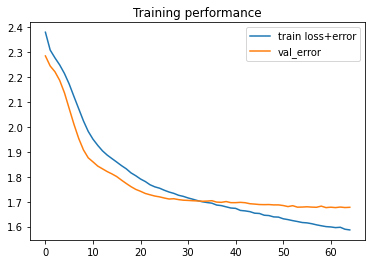

In [188]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [189]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

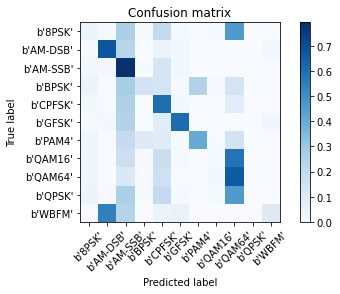

In [190]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [191]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])

#print(snr_label_array)
y_test_snr=snr_array[test_idx]



for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

Overall Accuracy:  0.09105603448275862 for SNR b'-20'
Overall Accuracy:  0.0939952546085052 for SNR b'-18'
Overall Accuracy:  0.09862964298593581 for SNR b'-16'
Overall Accuracy:  0.10168251645940014 for SNR b'-14'
Overall Accuracy:  0.11796246648793565 for SNR b'-12'
Overall Accuracy:  0.19532830605113113 for SNR b'-10'
Overall Accuracy:  0.2745931952662722 for SNR b'-8'
Overall Accuracy:  0.39155856020464097 for SNR b'-6'
Overall Accuracy:  0.5093223377554679 for SNR b'-4'
Overall Accuracy:  0.5119825708061002 for SNR b'-2'
Overall Accuracy:  0.50808526277104 for SNR b'0'
Overall Accuracy:  0.5094339622641509 for SNR b'2'
Overall Accuracy:  0.4918572735590119 for SNR b'4'
Overall Accuracy:  0.5046780407264722 for SNR b'6'
Overall Accuracy:  0.486695433297375 for SNR b'8'
Overall Accuracy:  0.49154653852998753 for SNR b'10'
Overall Accuracy:  0.4880757327507737 for SNR b'12'
Overall Accuracy:  0.5050045495905369 for SNR b'14'
Overall Accuracy:  0.49626253418413857 for SNR b'16'
Overal

In [195]:
print(acc)

{b'-20': 0.09105603448275862, b'-18': 0.0939952546085052, b'-16': 0.09862964298593581, b'-14': 0.10168251645940014, b'-12': 0.11796246648793565, b'-10': 0.19532830605113113, b'-8': 0.2745931952662722, b'-6': 0.39155856020464097, b'-4': 0.5093223377554679, b'-2': 0.5119825708061002, b'0': 0.50808526277104, b'2': 0.5094339622641509, b'4': 0.4918572735590119, b'6': 0.5046780407264722, b'8': 0.486695433297375, b'10': 0.49154653852998753, b'12': 0.4880757327507737, b'14': 0.5050045495905369, b'16': 0.49626253418413857, b'18': 0.5014771048744461}


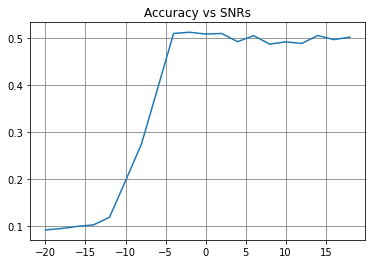

In [196]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.grid(linestyle="-", color='grey')
plt.plot(np.arange(-20,20,2), acc_array)